# Chapter 5: Pretraining on Unlabeled Data

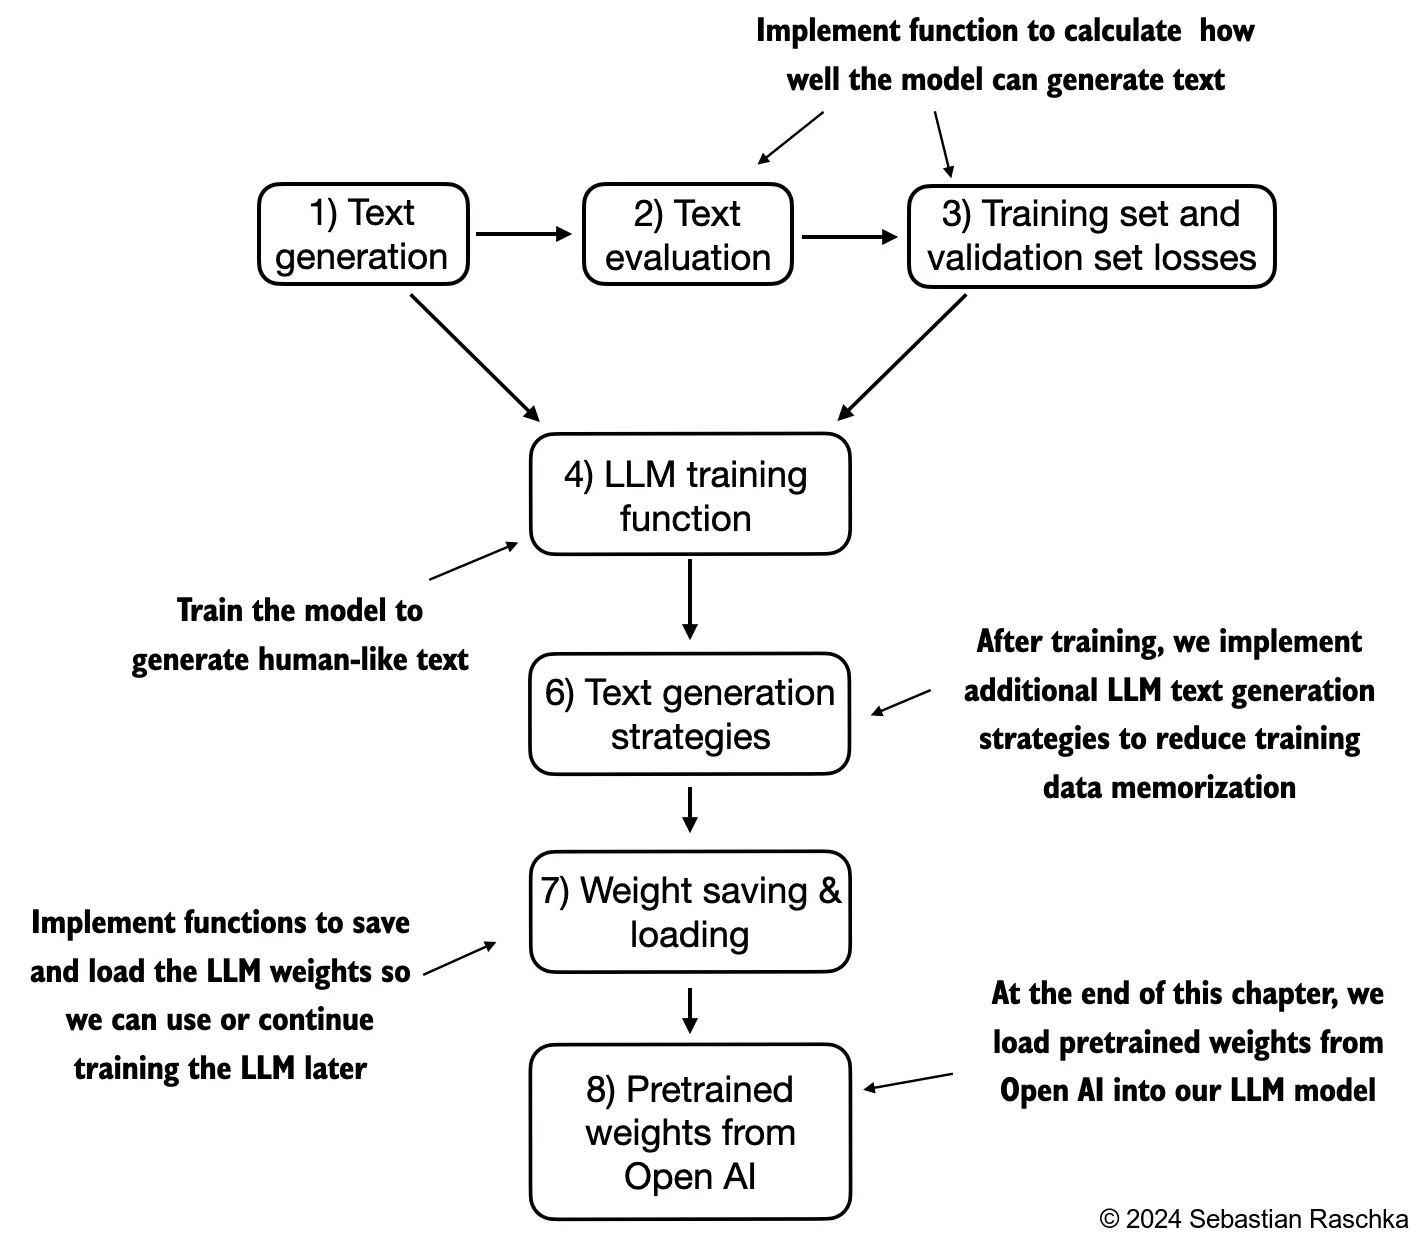

## 5.1 Evaluating generative text models

In [8]:
import torch
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [9]:
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [11]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                        [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [12]:
with torch.inference_mode():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [15]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [17]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

print(f"Targets batch 2: {token_ids_to_text(targets[1], tokenizer)}")
print(f"Outputs batch 2: {token_ids_to_text(token_ids[1].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix
Targets batch 2:  really like chocolate
Outputs batch 2:  pressuring empoweredfaith


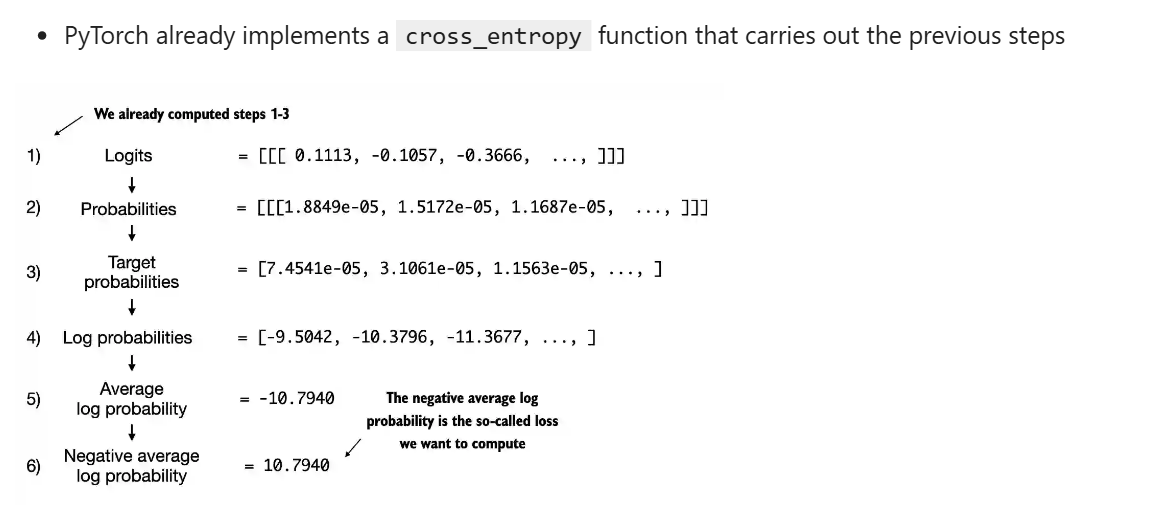

In [19]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [18]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
tensor(10.7940)


- A concept related to the cross-entropy loss is the perplexity of an LLM
- The perplexity is simply the exponential of the cross-entropy loss => better for sigmoid function

In [20]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- The perplexity is often considered more interpretable because it can be understood as **the effective vocabulary size** that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens)
- In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset
- Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution

In [21]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [23]:
# First 99 characters
print(text_data[:99])

# Last 99 characters
print(text_data[-99:])

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."
Characters: 20479
Tokens: 5145


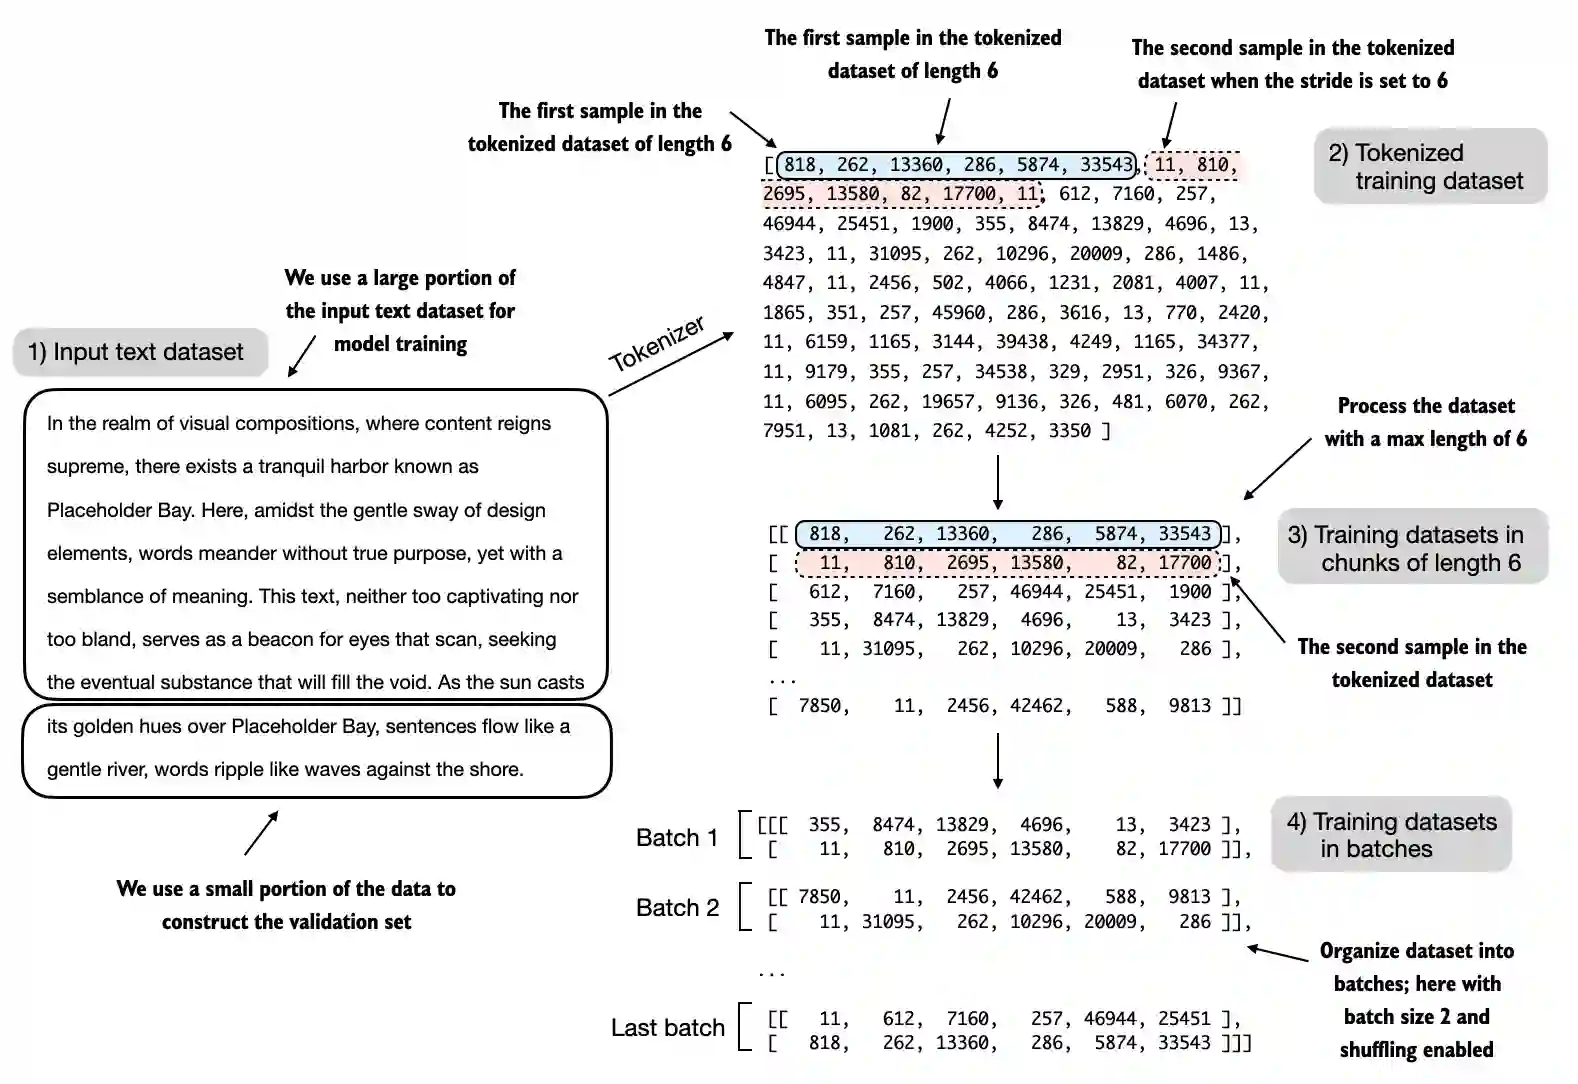

In [25]:
from previous_chapters import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90 # 90% training and 10% testing (validation)
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [26]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
        "Try to lower the `GPT_CONFIG_124M['context_length']` or "
        "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
        "Try to lower the `GPT_CONFIG_124M['context_length']` or "
        "decrease the `training_ratio`")

In [27]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [30]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

# Compare this sum with the original total calculated from the raw text file.
print("Previous total tokens:", total_tokens) # The number of tokens decreased, 
                # likely due to the DataLoader dropping the last incomplete batch.

Training tokens: 4608
Validation tokens: 512
All tokens: 5120
Previous total tokens: 5145


In [31]:
def calc_loss_batch(input_batch, target_batch, model, device):
    # Move the input and target batches to the specified device (e.g., "cuda" for GPU or "cpu").
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    
    # Perform a forward pass through the model to get the predicted logits.
    logits = model(input_batch)

    # Calculate the cross-entropy loss.
    # The logits tensor is reshaped from [batch_size, seq_len, vocab_size] to [batch_size * seq_len, vocab_size].
    # The target tensor is flattened from [batch_size, seq_len] to [batch_size * seq_len].
    # This is the standard format required by PyTorch's cross_entropy function.
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    # Initialize total loss to accumulate loss over batches.
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    
    elif num_batches is None:
        num_batches = len(data_loader)
        
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    
    # Iterate over the specified number of batches in the data loader.
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            # Calculate the loss for the current batch.
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # Add the scalar value of the loss to the total. .item() is used to prevent memory leaks
            # by detaching the loss from the computation graph.
            total_loss += loss.item()
        else:
            break
    # Return the average loss over the processed batches.
    return total_loss / num_batches



In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [33]:
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.inference_mode(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.98110580444336


## 5.2 Training an LLM

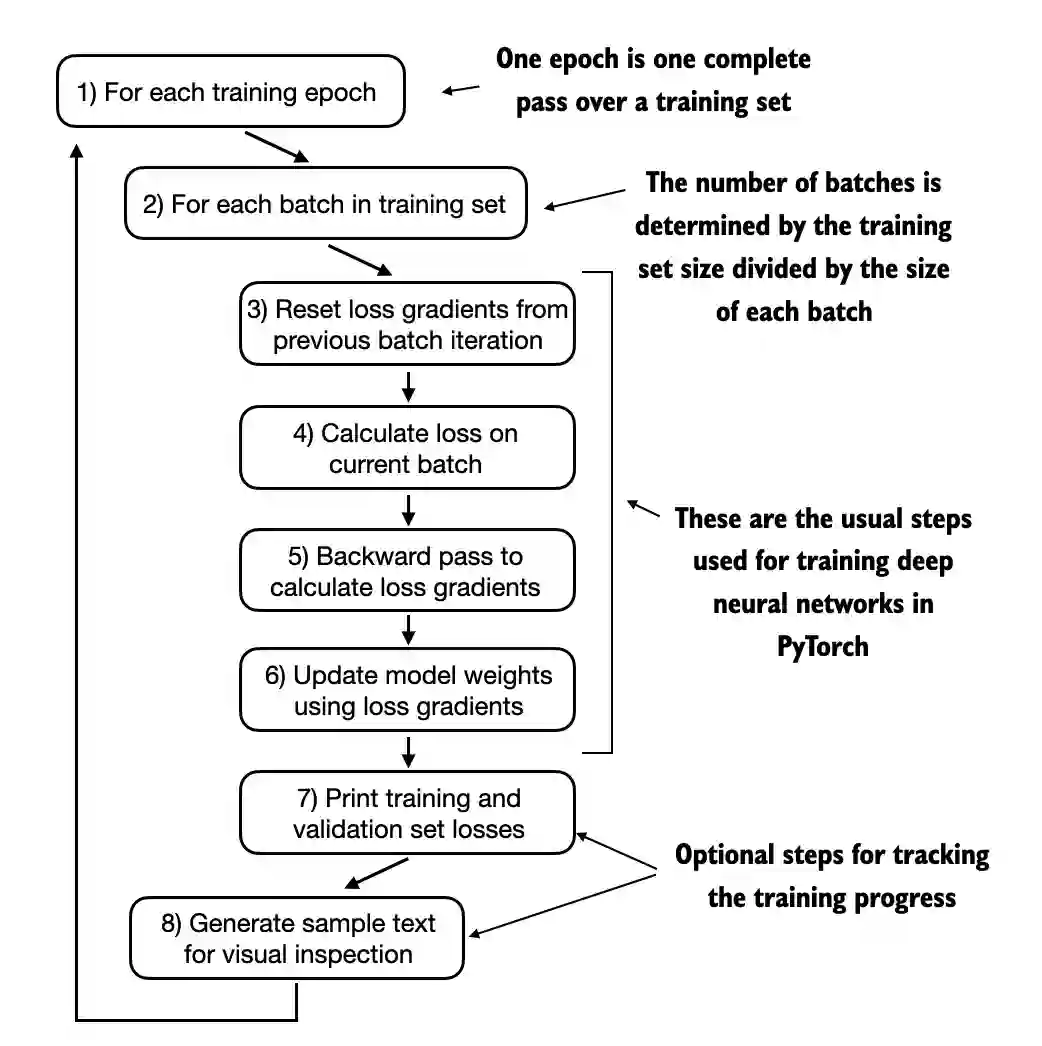

In [34]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                        eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                        f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.inference_mode():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.inference_mode():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [35]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.823, Val loss 9.932
Ep 1 (Step 000005): Train loss 8.065, Val loss 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.621, Val loss 7.051
Ep 2 (Step 000015): Train loss 6.043, Val loss 6.599
Every effort moves you, and,, and,, and,,,, and, and,,,,,,,,, and,,,, the,,,, and,, and,,, the, and,,,,,,
Ep 3 (Step 000020): Train loss 5.547, Val loss 6.485
Ep 3 (Step 000025): Train loss 5.450, Val loss 6.397
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 4.982, Val loss 6.301
Ep 4 (Step 000035): Train loss 4.755, Val loss 6.296
Every effort moves you, and I had been the of the picture to the picture.                                     
Ep 5 (Step 000040): Train loss 4.162, Val loss 6.182
Every effort moves you know the                                                

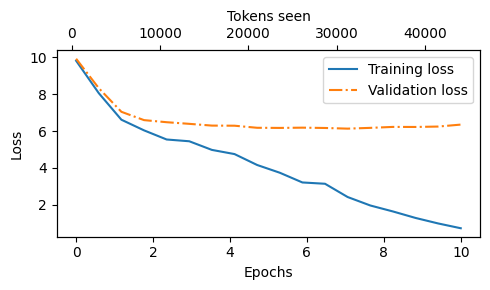

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [37]:
import math
ORIG_BOOK_VERSION = False


def train_model(model, train_loader, val_loader, optimizer, device,
                n_epochs, eval_freq, eval_iter, start_context, tokenizer,
                warmup_steps, initial_lr=3e-05, min_lr=1e-6):

    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    # Retrieve the maximum learning rate from the optimizer
    peak_lr = optimizer.param_groups[0]["lr"]

    # Calculate the total number of iterations in the training process
    total_training_steps = len(train_loader) * n_epochs

    # Calculate the learning rate increment during the warmup phase
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1

            # Adjust the learning rate based on the current phase (warmup or cosine annealing)
            if global_step < warmup_steps:
                # Linear warmup
                lr = initial_lr + global_step * lr_increment  
            else:
                # Cosine annealing after warmup
                progress = ((global_step - warmup_steps) / 
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            # Apply the calculated learning rate to the optimizer
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)  # Store the current learning rate

            # Calculate and backpropagate the loss
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            # Apply gradient clipping after the warmup phase to avoid exploding gradients
            if ORIG_BOOK_VERSION:
                if global_step > warmup_steps:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
            else:
                if global_step >= warmup_steps:  # the book originally used global_step > warmup_steps, which led to a skipped clipping step after warmup
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
            optimizer.step()
            tokens_seen += input_batch.numel()

            # Periodically evaluate the model on the training and validation sets
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # Print the current losses
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        # Generate and print a sample from the model to monitor progress
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen, track_lrs

In [38]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01

total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(warmup_steps)

27


In [39]:
import tiktoken

# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

peak_lr = 0.001  # this was originally set to 5e-4 in the book by mistake
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)  # the book accidentally omitted the lr assignment
tokenizer = tiktoken.get_encoding("gpt2")

n_epochs = 15
train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="Every effort moves you",
    tokenizer=tokenizer, warmup_steps=warmup_steps, 
    initial_lr=1e-5, min_lr=1e-5
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Iter 000000): Train loss 10.970, Val loss 10.938
Ep 1 (Iter 000005): Train loss 9.336, Val loss 9.460
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 7.822, Val loss 8.188
Ep 2 (Iter 000015): Train loss 6.341, Val loss 6.893
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000020): Train loss 6.073, Val loss 6.595
Ep 3 (Iter 000025): Train loss 5.684, Val loss 6.764
Every effort moves you, the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the
Ep 4 (Iter 000030): Train loss 5.727, Val loss 6.805
Ep 4 (Iter 000035): Train loss 5.788, Val loss 6.851
Every effort moves you.                                                 
Ep 5 (Iter 000040): Train loss 5.246, Val loss 6.554
Every effort moves you, and in the a a, and I had the picture a little of the picture, and I had been, and

## 5.3 Decoding strategies to control randomness

In [42]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### 5.3.1 Temperature scaling
- Previously, we always sampled the token with the highest probability as the next token using `torch.argmax`
- To add variety, we can sample the next token using The `torch.multinomial(probs, num_samples=1)`, sampling from a probability distribution
- Here, each index's chance of being picked corresponds to its probability in the input tensor

In [43]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [50]:
# torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [44]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


- We can control the distribution and selection process via a concept called temperature scaling
- "Temperature scaling" is just a fancy word for dividing the logits by a number greater than 0
- Temperatures greater than 1 will result in more uniformly distributed token probabilities after applying the softmax
- Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions after applying the softmax

In [51]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

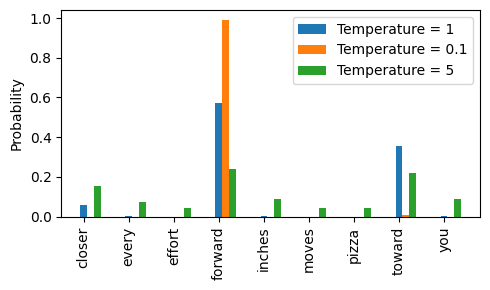

In [52]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [53]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


In [54]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


### Top-k sampling
To be able to use higher temperatures to increase output diversity and to reduce the probability of nonsensical sentences, we can restrict the sampled tokens to the top-k most likely tokens:

In [55]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits) # returns them ordered
print("Top positions:", top_pos) # returns the indecies ordered by the values of the logits

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [56]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1], # less than the last logit which has the lowest prob (bec they are ordered)
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [58]:
# NOTE: An alternative, slightly more efficient implementation of the previous code cell is the following:

new_logits = torch.full_like( # create tensor containing -inf values with the size of next_token_logits
    next_token_logits, -torch.inf
)   
print(new_logits)

new_logits[top_pos] = next_token_logits[top_pos] # copy top k values into the -inf tensor
print(new_logits)

tensor([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [59]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 Modifying the text generation function

In [61]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.inference_mode():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [68]:
# torch.manual_seed(123)

for i in range(5):
    token_ids = generate(
        model=model,
        idx=text_to_token_ids("Every effort moves you", tokenizer),
        max_new_tokens=15,
        context_size=GPT_CONFIG_124M["context_length"],
        top_k=25,
        temperature=1.4
    )

    print(f"Output text {i+1}:\n", token_ids_to_text(token_ids, tokenizer))
    print("======================================================")

Output text 1:
 Every effort moves you know," was him his my hostess was "interesting":chairs anyanim
Output text 2:
 Every effort moves you in terrace. He--she by a degree a tone told me in
Output text 3:
 Every effort moves you thought Jack's open-stream felt able to face the fact with random-
Output text 4:
 Every effort moves you know.
"Yes--quite insensible to do the house."

Output text 5:
 Every effort moves you?"It was him that that tried some lying him, irony. To the


## 5.4 Loading and saving model weights in PyTorch

In [70]:
# you can save the state dict of he optimizer too :O
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)


checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 5.5 Loading pretrained weights from OpenAI

In [71]:
import tensorflow, tqdm

tensorflow.__version__, tqdm.__version__

('2.19.0', '4.67.1')

In [73]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 15.4kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:03<00:00, 338kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 45.0kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [04:06<00:00, 2.02MiB/s]  
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 2.62MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 565kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 547kiB/s] 


In [74]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [75]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

- The next task is to assign the OpenAI weights to the corresponding weight tensors in our GPTModel instance
> From `tensorflow` to `pytorch`


I don't understand what he did here but surly here is a better way to do this right?...

In [78]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [79]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [82]:
# torch.manual_seed(123)


for i in range(5):
    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
        max_new_tokens=25,
        context_size=NEW_CONFIG["context_length"],
        top_k=50,
        temperature=1.5
    )

    print(f"Output text{i+1}:\n", token_ids_to_text(token_ids, tokenizer))
    print("===================================================================")

Output text1:
 Every effort moves you forward. "The key comes from how we create space here … You have only this space now … if you don't have
Output text2:
 Every effort moves you so far from where you are. I'm always saying, how can we teach you to become more conscious of my pain for
Output text3:
 Every effort moves you in other directions but only once before a single word occurs within these five phases. Every change in position within these steps can be
Output text4:
 Every effort moves you further ahead—and at times—to help a man or the people that deserve to know him, rather than simply moving forward
Output text5:
 Every effort moves you and those working with you.

One example involves a project I did back here this morning in St Petersburg, but would


In [83]:
torch.save({
    "model_state_dict": gpt.state_dict(),
    }, 
    "gpt.pth"
)